# Overview
This notebook provides instructions on how to use CEFCON for the following tasks: 
- constructing cell-lineage-specific GRNs,
- identifying driver regulators,
- finding regulon-like gene modules,
- visualizing and analyzing the results.

We use the scRNA-seq data from Nestorowa et al. (2016, Blood), which is about mouse hematopoietic stem and progenitor cell differentiation.

### Contents
- [1. Load the preprocessed data](#section1)
- [2. Construct cell-lineage-specific GRNs](#section2)
- [3. Identify driver regulators for each developmental lineage](#section3)
- [4. Find regulon-like gene modules (RGMS)](#section4)
- [5. Visualization and analyses of results](#section5)

In [1]:
import cefcon as cf
import matplotlib.pyplot as plt
import scanpy as sc
import warnings
warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["savefig.dpi"] = 300
plt.rcParams["figure.figsize"] = [6, 4.5]

In [17]:
# Load the preprocessed data
adata = sc.read("../../h5ad/v3_3KHVGs_classial_Prog_RR_subset_cefcon.h5ad")
adata

AnnData object with n_obs × n_vars = 10000 × 3000
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'GEM', 'prog', 'disease', 'sex', 'pair', 'age', 'edss', 'disease.state', 'prog_sex', 'disease_sex', 'disease.state_sex', 'unintegrated_clusters', 'seurat_clusters', 'disease.patient', 'celltypes', 'celltypes.disease', 'celltypes.disease.state', 'leiden'
    var: 'vf_vst_counts.1_mean', 'vf_vst_counts.1_variance', 'vf_vst_counts.1_variance.expected', 'vf_vst_counts.1_variance.standardized', 'vf_vst_counts.1_variable', 'vf_vst_counts.1_rank', 'vf_vst_counts.2_mean', 'vf_vst_counts.2_variance', 'vf_vst_counts.2_variance.expected', 'vf_vst_counts.2_variance.standardized', 'vf_vst_counts.2_variable', 'vf_vst_counts.2_rank', 'vf_vst_counts.3_mean', 'vf_vst_counts.3_variance', 'vf_vst_counts.3_variance.expected', 'vf_vst_counts.3_variance.standardized', 'vf_vst_counts.3_variable', 'vf_vst_counts.3_rank', 'vf_vst_counts.4_mean', 'vf_vst_counts.4_variance', 'vf_vst_counts.4_variance.expected',

In [47]:
adata.obs["prog"]

GEM26_AAGGTAATCATGCAGT-1    progressor
GEM23_GTTAGTGAGTGACACG-1            RR
GEM26_AGATAGACACGAAGAC-1    progressor
GEM4_CACGAATGTCACTCAA-1     progressor
GEM22_GACTTCCGTTTGGGTT-1    progressor
                               ...    
GEM10_ACAACCATCCCGAATA-1    progressor
GEM10_ATCGGATCAACGGTAG-1    progressor
GEM10_GACCCTTGTACCTAAC-1    progressor
GEM5_CAACGGCAGAGGGTGG-1             RR
GEM21_CGAGTTATCAATCAGC-1            RR
Name: prog, Length: 10000, dtype: category
Categories (2, object): ['RR', 'progressor']

In [25]:
import numpy as np
data_matrix = adata.X

# Convert the data matrix to float
data_matrix_float = data_matrix.astype(np.float32)
adata.X = data_matrix_float

Load the prior gene interaction network

In [18]:
prior_network = cf.datasets.load_human_prior_interaction_network(dataset='nichenet')
# Convert the gene symbols of the prior gene interaction network to the mouse gene symbols
# prior_network = cf.datasets.convert_human_to_mouse_network(prior_network)

Load the prior gene interaction network: nichenet. #Genes: 25345, #Edges: 5290993


Alternatively, you can directly specify the file path of the input prior interaction network and import the specified file using the `cf.data_preparation` function.

In [12]:
prior_network = 'network_human.csv'

In [26]:
data = cf.data_preparation(adata, prior_network)

[0] - Data loading and preprocessing...
Consider the input data with 1 lineages:
  Lineage - all:
    590 extra edges (Spearman correlation > 0.6) are added to the prior gene interaction network.
    Total number of edges: 68350.
    n_genes × n_cells = 2038 × 10000


Assign a CUDA device:

In [27]:
CUDA = '0'

In [28]:
data

{'all': AnnData object with n_obs × n_vars = 10000 × 2038
     var: 'is_TF'
     uns: 'name', 'edgelist'
     varm: 'centrality_prior_net', 'idx_GeneName_map'}

In [29]:
%%time
cefcon_results_dict = {}
for li, data_li in data.items():
    # We suggest setting up multiple repeats to minimize the randomness of the computation.
    cefcon_GRN_model = cf.NetModel(epochs=350, repeats=3, cuda=CUDA, seed=-1)
    cefcon_GRN_model.run(data_li)

    cefcon_results = cefcon_GRN_model.get_cefcon_results(edge_threshold_avgDegree=8)
    cefcon_results_dict[li] = cefcon_results

[1] - Constructing cell-lineage-specific GRN...
  Lineage - all: 


  Iter: 3/3: 100%|███████████████| 350/350 [00:55<00:00,  6.34it/s, loss=0.000156, min_loss=6.77e-5]


CPU times: user 2min 47s, sys: 315 ms, total: 2min 47s
Wall time: 2min 46s


In [30]:
%%time
for li, result_li in cefcon_results_dict.items():
    print(f'Lineage - {li}:')
    result_li.gene_influence_score()
    result_li.driver_regulators()

Lineage - all:
[2] - Identifying driver regulators...
Restricted license - for non-production use only - expires 2025-11-24
  Solving MFVS problem...
    71 critical nodes are found.
    0 nodes left after graph reduction operation.
  71 MFVS driver genes are found.
  Solving MDS problem...
    14 critical nodes are found.
    765 nodes left after graph reduction operation.
    Solving the Integer Linear Programming problem on the reduced graph...
      Solving by GUROBI...(optimal value with GUROBI:158.0,  status:optimal)
  172 MDS driver genes are found.
CPU times: user 95.6 ms, sys: 3.02 ms, total: 98.6 ms
Wall time: 97.5 ms


In [31]:
%%time
for li, result_li in cefcon_results_dict.items():
    print(f'Lineage - {li}:')
    result_li.RGM_activity()

Lineage - all:
[3] - Identifying regulon-like gene modules...
Done!
CPU times: user 1.02 s, sys: 751 ms, total: 1.77 s
Wall time: 7.06 s


In [33]:
# Check the names of lineages
print(list(data.keys()))

['all']


In [34]:
lineage = 'all'
result = cefcon_results_dict[lineage]

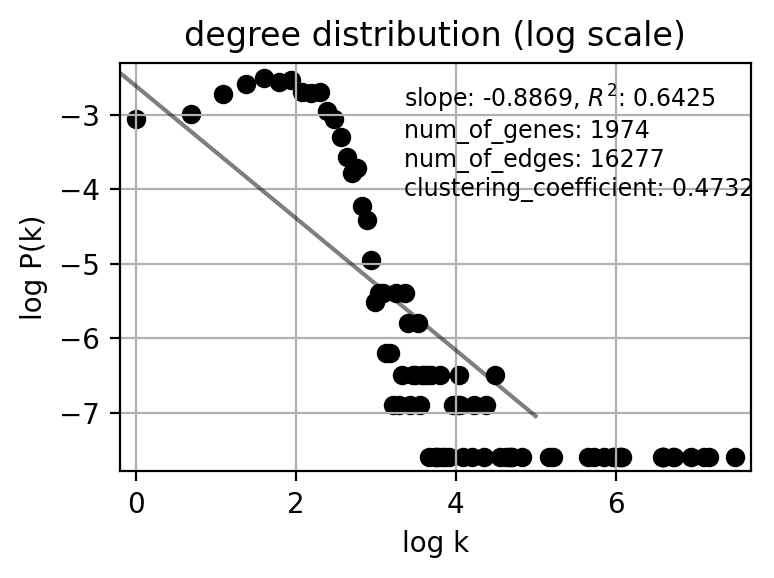

In [35]:
result.plot_network_degree_distribution()

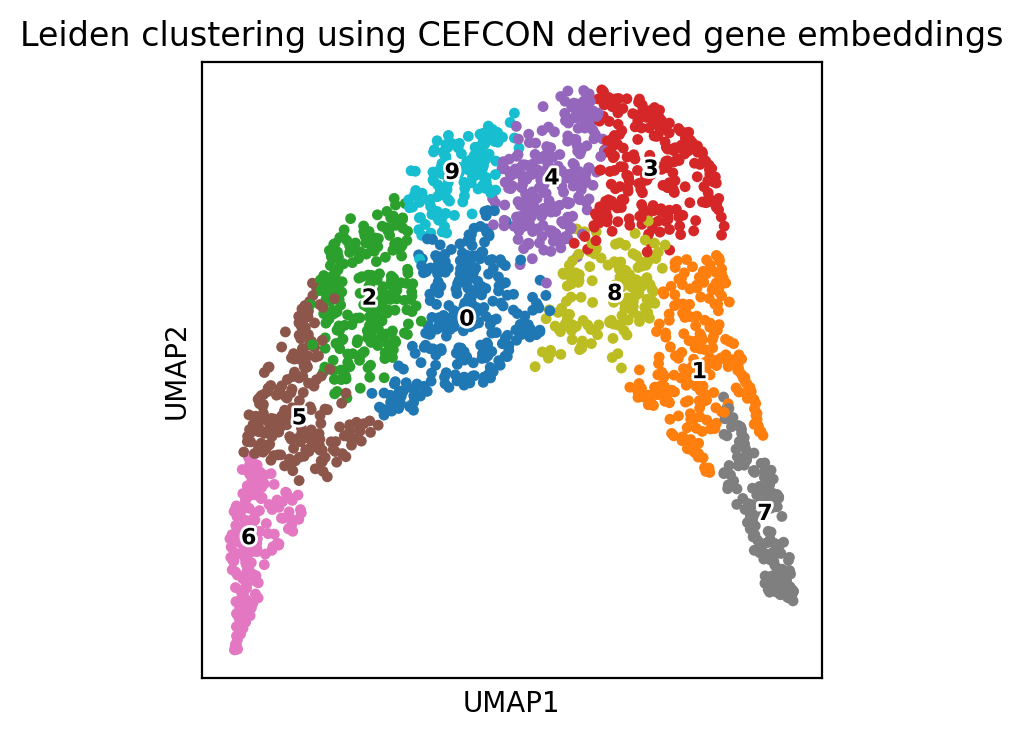

In [36]:
result.plot_gene_embedding_with_clustering(n_neighbors=30, resolution=1)

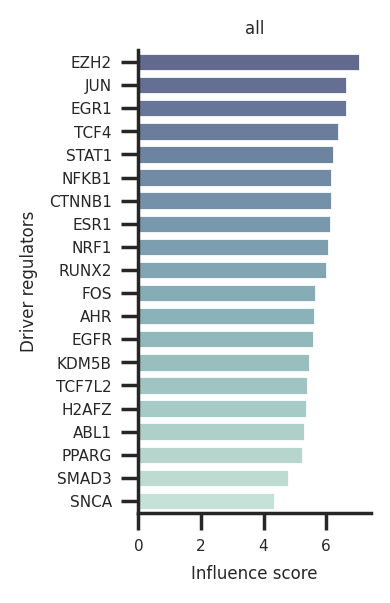

In [37]:
result.plot_influence_score()

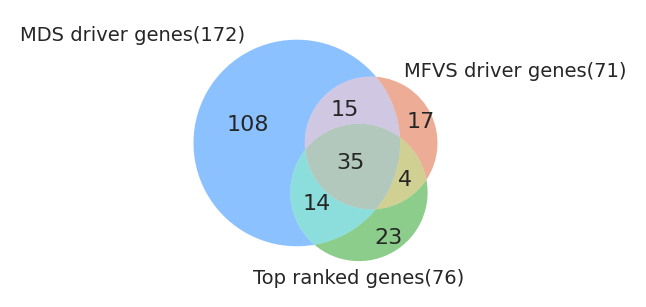

In [38]:
result.plot_driver_genes_Venn()

In [46]:
result.plot_RGM_activity_heatmap(cell_label= 'prog', type='all')

AttributeError: 'str' object has no attribute 'unique'

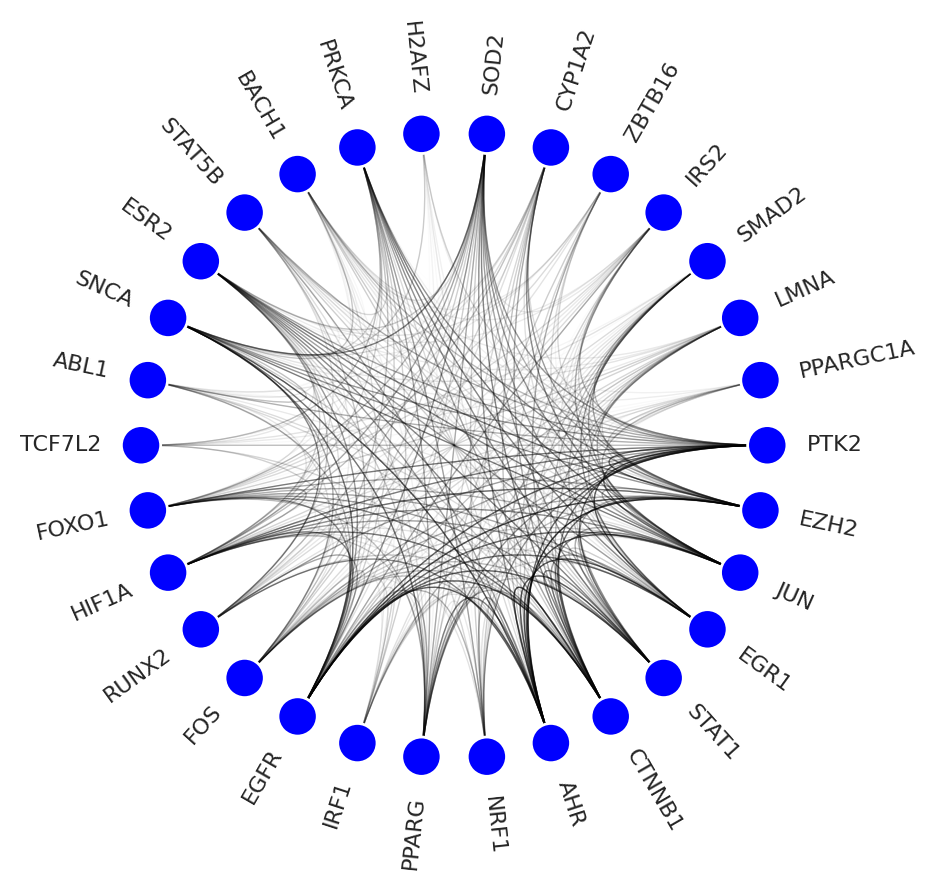

In [22]:
genes = result.driver_regulator.index[0:30]

network = result.plot_network(genes)

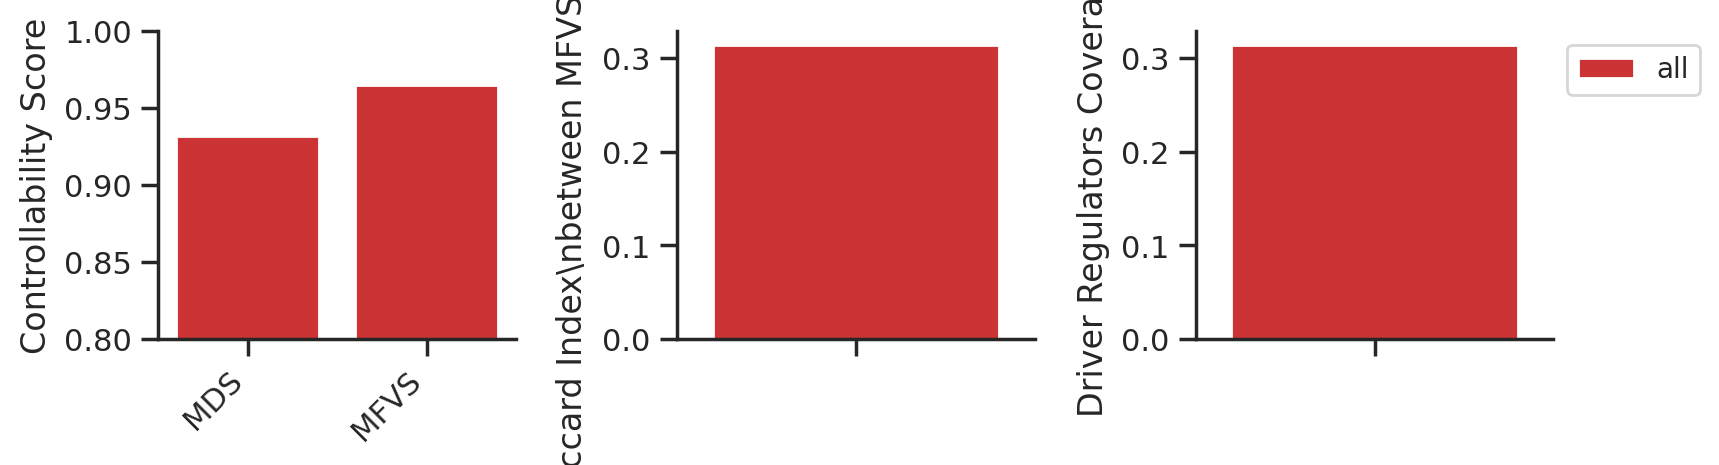

In [23]:
cf.utils.plot_controllability_metrics(cefcon_results_dict, return_value=False)
